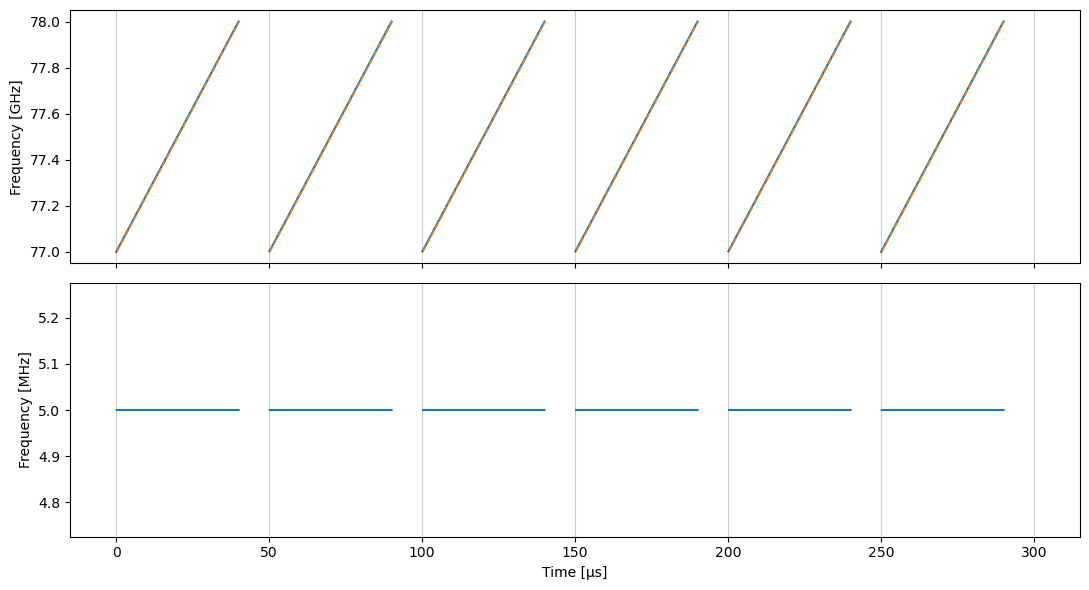

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Parameters ------------------
c = 3e8                 # Speed of light [m/s]
f0 = 77e9               # Start frequency [Hz]
B = 1e9                 # Bandwidth per chirp [Hz]
T_chirp = 40e-6         # Chirp duration [s]
T_idle  = 10e-6         # Idle time [s]
N_chirps = 6            # Number of chirps
R = 30.0                # Target range [m]
v = 0.0                 # Target velocity [m/s] (0 -> stationary)
fs = 10e6               # Sampling rate [Hz]

# Derived quantities
S   = B / T_chirp                 # Slope [Hz/s]
tau = 2 * R / c                   # Propagation delay [s]
lam = c / f0                      # Wavelength [m]
fD  = 2 * v / lam                 # Doppler frequency [Hz] (monostatic)
T_per   = T_chirp + T_idle        # Chirp period [s]
T_total = N_chirps * T_per        # Total duration [s]

# Time axis
t = np.arange(0, T_total, 1/fs)

# Local time within one period (sawtooth)
def local_time(u):
    return u - np.floor(u / T_per) * T_per

t_tx = local_time(t)               # local TX time
t_rx = local_time(t - tau)         # local RX time (delayed)

# Active masks (active only during chirp)
mask_tx   = (t_tx >= 0) & (t_tx < T_chirp)
mask_rx   = (t_rx >= 0) & (t_rx < T_chirp)
mask_both = mask_tx & mask_rx      # mixing is meaningful only there

# Instantaneous frequencies (NaN outside chirps -> visible gaps)
f_tx = np.full_like(t, np.nan, float)
f_rx = np.full_like(t, np.nan, float)
f_tx[mask_tx] = f0 + S * t_tx[mask_tx]
f_rx[mask_rx] = f0 + S * t_rx[mask_rx] + fD

# Beat frequency: f_b = S * tau + fD (for up-chirp, small v)
f_b_th = S * tau + fD
f_b_t  = np.full_like(t, np.nan, float)
f_b_t[mask_both] = f_b_th

# ------------------ Plots ------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,6), sharex=True, facecolor="none")
for ax in (ax1, ax2):
    ax.set_facecolor('none')
# (1) TX/RX frequencies
ax1.plot(t*1e6, f_tx/1e9, label="TX-Chirp", lw=1.5)
ax1.plot(t*1e6, f_rx/1e9, '--', label="RX (verzögert)", lw=1.2)
ax1.set_ylabel("Frequency [GHz]")
#ax1.set_title("FMCW: Multiple chirps (frequency evolution) + beat frequency")
ax1.grid(False)
#ax1.legend(loc="upper left")

# (Chirp boundaries for orientation)
for n in range(N_chirps + 1):
    x = (n*T_per)*1e6
    ax1.axvline(x, color="k", alpha=0.2, lw=0.8)
    ax2.axvline(x, color="k", alpha=0.2, lw=0.8)

# (2) Beat frequency (drawn only during chirps)
ax2.plot(t*1e6, f_b_t/1e6, lw=1.5)
ax2.set_xlabel("Time [µs]")
ax2.set_ylabel("Frequency [MHz]")
ax2.grid(False)
#ax2.text(0.01, 0.88, fr"$f_b = S\tau + f_D \approx {f_b_th/1e6:.2f}\,\mathrm{{MHz}}$", transform=ax2.transAxes)

plt.tight_layout()
plt.gca().set_facecolor('none')
plt.show()
